# Example: Static forward free-boundary equilibrium calculations

---

This example notebook shows how to use FreeGSNKE to solve **static forward** free-boundary Grad-Shafranov (GS) problems.

In the **forward** solve mode we solve for the plasma equilibrium using user-defined active poloidal field coil currents, passive structure currents, and plasma current density profiles. 

Below, we illustrate how to use the solver for both diverted and limited plasma configurations in a **MAST-U-like tokamak** using stored pickle files containing the machine description. These machine description files partially come from the FreeGS repository and are not an exact replica of MAST-U. 

##### Note:
It is recommended to go through the inverse solver notebook before this one as we omit many of the commonly shared details!

### Import packages

We'll now go through the steps required to solve the **forward** problem in FreeGSNKE. 

In [10]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

First, we build the machine object. This is done using the pickle files saved in the "machine_configs/MAST-U" directory. 

FreeGSNKE requires the following envirnoment variables in order to build the machine:
- `ACTIVE_COILS_PATH`
- `PASSIVE_COILS_PATH`
- `WALL_PATH`
- `LIMITER_PATH`
- `PROBE_PATH` (not required here).

In [11]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"

In [12]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


### Instantiate an equilibrium

In [13]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

### Instantiate a profile object

See inverse solver notebook for a list of some of the different profile objects available in FreeGSNKE. Later on, we will try some of these out. 

Here, we will use the `ConstrainPaxisIp` profile.

In [14]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties. The solver below can be used for both inverse and forward solve modes.

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid, and tokamak are consistent across solves. 

In [15]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Define the coil currents

As mentioned before, during a forward solve, we use fixed coil currents (as well as given profile functions/parameters) as inputs to solve for the equilibrium. To do this, we can use the set of currents we identified within the inverse solve notebook. Note that the passive structure currents are zero. 

In [16]:
# load the coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    currents_dict = pickle.load(f)
    
# assign currents to the eq object
for key in currents_dict.keys():
    eq.tokamak.set_coil_current(coil_label=key, current_value=currents_dict[key])
    
eq.tokamak.getCurrents()

{'Solenoid': 5000,
 'PX': 3651.0769901740773,
 'D1': 8942.539917412247,
 'D2': -616.2886050111157,
 'D3': 5143.623600621425,
 'Dp': -2345.683712883073,
 'D5': 1049.5821472120365,
 'D6': 81.22652499448158,
 'D7': -412.8759370829901,
 'P4': -3569.2766996309892,
 'P5': -4021.3241912097365,
 'P6': -37.84574081996122,
 'vessel_1': 0,
 'vessel_2': 0,
 'vessel_3': 0,
 'vessel_4': 0,
 'vessel_5': 0,
 'vessel_6': 0,
 'vessel_7': 0,
 'vessel_8': 0,
 'vessel_9': 0,
 'vessel_10': 0,
 'vessel_11': 0,
 'vessel_12': 0,
 'vessel_13': 0,
 'vessel_14': 0,
 'vessel_15': 0,
 'vessel_16': 0,
 'vessel_17': 0,
 'vessel_18': 0,
 'vessel_19': 0,
 'vessel_20': 0,
 'vessel_21': 0,
 'vessel_22': 0,
 'centrecolumn_1': 0,
 'centrecolumn_2': 0,
 'centrecolumn_3': 0,
 'centrecolumn_4': 0,
 'centrecolumn_5': 0,
 'centrecolumn_6': 0,
 'centrecolumn_7': 0,
 'centrecolumn_8': 0,
 'centrecolumn_9': 0,
 'centrecolumn_10': 0,
 'colosseum_upper_1': 0,
 'colosseum_upper_2': 0,
 'colosseum_upper_3': 0,
 'colosseum_lower_1': 0,

### The forward solve

The syntax of a forward solve is identical to that of an inverse call (i.e. calling `GSStaticSolver.solve()`), however the nonlinear solver is **not** provided with a `constrain` object (i.e. we set `constrain=None`). 

Therefore, coil current values are not modified during the solve but instead the solver uses them as inputs to calculate the equilibrium. 

FreeGSNKE uses a Newton-Krylov (NK) method to solve the static forward problem stated in the inverse solve notebook (which we re-write below as a root-problem, boundary condition omitted here):

$$ \Delta^* \psi + \mu_0 R J_{\phi}(\psi,R,Z) = 0, \qquad (R,Z) \in \Omega. $$

Given the coil flux $\psi_c$ is known prior to solving, we only require an initial guess for the plasma flux $\psi_p$. This is generated automatically in FreeGSNKE and scaled automatically according to the size of the coil currents and/or plasma current. If a good initial guess is known, it can be provided to the solver in the equilbirium object above via the `psi` option. 

The NK method helps mitigate the numerical instability problems associated with Picard-based iterations and enables considerably more restrictive tolerance requests. The stopping criterion is defined as

$$ \frac{\text{max} | \psi^{(n+1)} - \psi^{(n)} |}{\text{max} \ \psi^{(n)} - \text{min} \ \psi^{(n)}} < \varepsilon, $$

where $n$ is the iteration number. 

In [17]:
# call the solver
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9,
                     verbose=True, # print output
                     )

rescaling accepted by0.17985878990921358
Initial guess for plasma_psi successful, residual found.
Initial relative error =  1.0068234430980187
-----
Picard iteration: 0
...relative error =  0.9370284747469712
-----
Picard iteration: 1
...relative error =  0.8236564874862011
-----
Picard iteration: 2
...relative error =  0.7042611325892131
-----
Picard iteration: 3
...relative error =  0.5677868530638052
-----
Picard iteration: 4
...relative error =  0.41584436821279264
-----
Picard iteration: 5
...relative error =  0.2531192033001805
-----
Picard iteration: 6
...relative error =  0.1434323759387353
-----
Picard iteration: 7
Increase in residual, update reduction triggered.
...relative error =  0.11902453498342253
-----
Picard iteration: 8
...relative error =  0.09390167227665407
-----
Newton-Krylov iteration: 9
New starting_direction used due to collinear residuals.
...relative error =  0.05246080110615383
-----
Newton-Krylov iteration: 10
Increase in residual, update reduction trigger

What we have done here is improve on the equilibrium found during the inverse solve by taking the coil currents (found during the inverse solve) and the same profile parameters and feeding them into the forward solver. 

We do this because it is often difficult to achieve low relative tolerances in _inverse_ solve calls (for example, the above was set at a loose target_relative_tolerance=1e-6) and so the strategy of using a forward solve after an inverse one is useful to obtain better (more converged) equilibria at stricter tolerances.

As an additional example, below we manually vary some of the coil currents, perform new forward solves and compare the resulting equilibria.
Note that the manual current changes cause one of the equilibria to transition from a diverted to a limiter configuration (this is handled through FreeGS4E).

rescaling accepted by0.8264462809917354


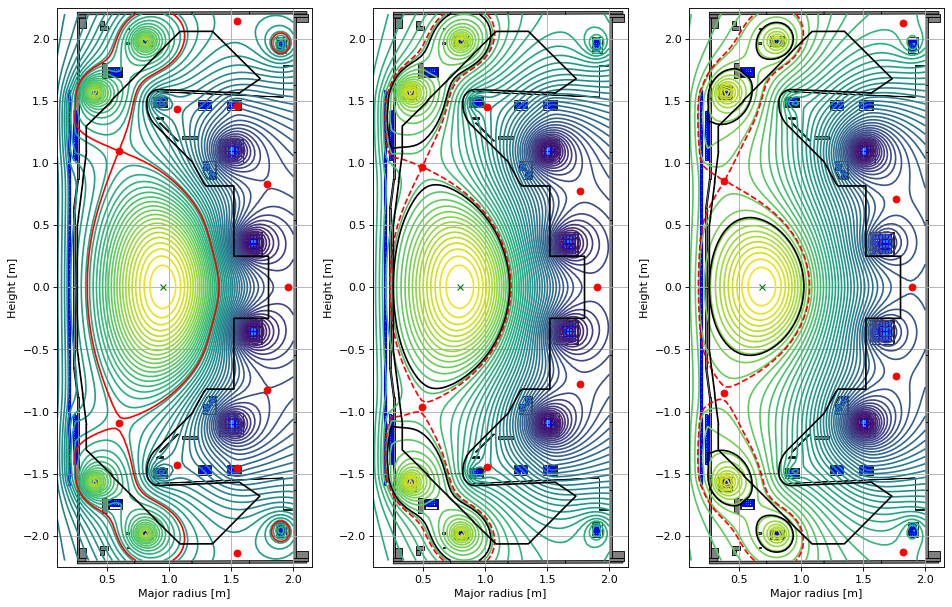

In [18]:
from copy import deepcopy

# copy the original eq object (for the new forward solves with modified currents)
eq_forward_1 = deepcopy(eq)
eq_forward_2 = deepcopy(eq)

# modify the P4 current and solve
eq_forward_1.tokamak.set_coil_current('P4', 1.5*eq.tokamak['P4'].current)
GSStaticSolver.solve(eq=eq_forward_1, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# modify the P4 current (even more) and solve
eq_forward_2.tokamak.set_coil_current('P4', 1.5**2 * eq.tokamak['P4'].current)
GSStaticSolver.solve(eq=eq_forward_2, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

# original 
ax1.grid(True, which='both')
eq.plot(axis=ax1,show=False)
eq.tokamak.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

# modified 1
ax2.grid(True, which='both')
eq_forward_1.plot(axis=ax2,show=False)
eq_forward_1.tokamak.plot(axis=ax2,show=False)
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)

# modified 2 (now limited plasma)
ax3.grid(True, which='both')
eq_forward_2.plot(axis=ax3,show=False)
eq_forward_2.tokamak.plot(axis=ax3,show=False)
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

### Alternative profile functions
Here, we will illustrate how to use some of the other available profile objects.

We'll start with the `ConstrainBetapIp` object.

In [19]:
from freegsnke.jtor_update import ConstrainBetapIp

profiles_beta = ConstrainBetapIp(
    eq=eq,
    betap=0.05,
    Ip=6e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

We can then use it directly in a new solve (with the coil currents found by the inverse solve).

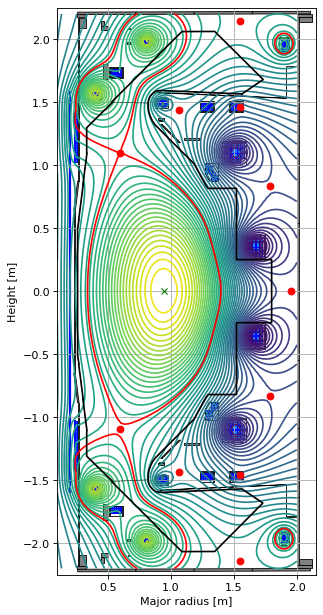

In [20]:
# instatiate new equilibrium object
eq_beta = deepcopy(eq)

# call solver with new profile object
GSStaticSolver.solve(eq=eq_beta, 
                     profiles=profiles_beta, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq_beta.plot(axis=ax1, show=False)
eq_beta.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

We can also use the `Fiesta_Topeol` profile (see equation 13 in L. L. Lao et al (1985) Nucl. Fusion 25 1611). This has the same parameterisation as the previous two profiles except that we can now specify the  `Beta0` parameter directly.

In [21]:
from freegsnke.jtor_update import Fiesta_Topeol

profiles_topeol = Fiesta_Topeol(
    eq=eq,        # equilibrium object
    Beta0=0.3665, # beta0 parameter
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=2,    # profile function parameter
    alpha_n=1     # profile function parameter
)

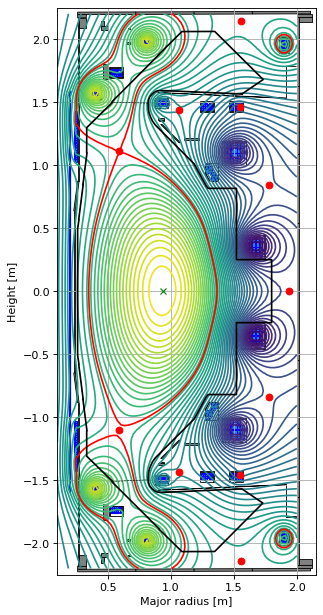

In [22]:
# instatiate new equilibrium object
eq_topeol = deepcopy(eq)

# call solver with new profile object
GSStaticSolver.solve(eq=eq_topeol, 
                     profiles=profiles_topeol, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq_topeol.plot(axis=ax1, show=False)
eq_topeol.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

We now test the `Lao85` profile (see equations 4 and 5 in L. L. Lao et al (1985) Nucl. Fusion 25 1611).

These profiles are parametrised as:

 $$J_{p}(\psi, R, Z) = \lambda\big[ \frac{R}{R_{0}} p'(\tilde{\psi}) + \frac{R_0}{R} \frac{1}{\mu_0} F F'(\tilde{\psi}) \big] \quad (R,Z) \in \Omega_p, $$
where the pressure and toroidal current profiles are given by
$$ p'(\tilde{\psi}) = \sum_{i=0}^{n_p} \alpha_i \tilde{\psi}^i - \hat{\alpha} \tilde{\psi}^{n_p + 1} \sum_{i=0}^{n_p} \alpha_i$$
and
$$ F F'(\tilde{\psi}) = \sum_{i=0}^{n_F} \beta_i \tilde{\psi}^i - \hat{\beta} \tilde{\psi}^{n_F + 1} \sum_{i=0}^{n_F} \beta_i.$$ 

The required parameters are:
- `Ip` (total plasma current).
- `fvac` ($rB_{tor}$,  vacuum toroidal field strength).
- `alpha` (array of alpha coefficients).
- `beta` (array of beta coefficients).
- `alpha_logic`, and `beta_logic` (Booleans that correspond to $\hat{\alpha}$ and $\hat{\beta}$ above, sets boundary condition for plasma current at plasma boundary).
- `Ip_logic` (if False, `Ip` is not used, if True, `Ip` is used to normalise $J_p$ and find $\lambda$).

We can use the Lao85 profile to set up the same identical equilibrium as generated by the Topeol profile. 

In the Topeol profiles, we have $\alpha_m = 2$ and $\alpha_n = 1$ which means both $p'$ and $FF'$ are proportional to $1 - \psi_n^2$ (with $\hat{\alpha} = \hat{\beta} = 1$. This corresponds to (the vectors) $\alpha, \beta \propto (1, 0 , -1)$ - check this. 

We also need to take into account the scalings: alpha over beta is mu0.

In [23]:
from freegsnke.jtor_update import Lao85
from freegs4e.gradshafranov import mu0   # permeability

alpha = np.array([1,0,-1])
beta = (1 - profiles_topeol.Beta0)/profiles_topeol.Beta0 * alpha * mu0

profiles_lao = Lao85(
    eq=eq,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=False,
    beta_logic=False,
    Ip_logic=True,
)

Note that above we're providing as input the full list of alpha and beta coefficients and therefore setting both logic inputs to False.
The following is entirely equivalent to the above:

```python
alpha = np.array([1,0])
beta = (1 - profiles_topeol.Beta0)/profiles_topeol.Beta0 * alpha * mu0

profiles_lao = Lao85(
    eq=eq_forward,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=True,
    beta_logic=True,
    Ip_logic=True,
)
```

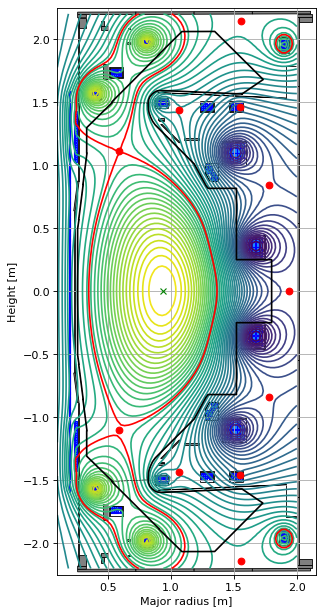

In [24]:
# instatiate new equilibrium object
eq_lao = deepcopy(eq)

# call solver with new profile object
GSStaticSolver.solve(eq=eq_lao, 
                     profiles=profiles_lao, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq_lao.plot(axis=ax1, show=False)
eq_lao.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

The following illustrates that the two profile functions indeed generate the same current distribution.

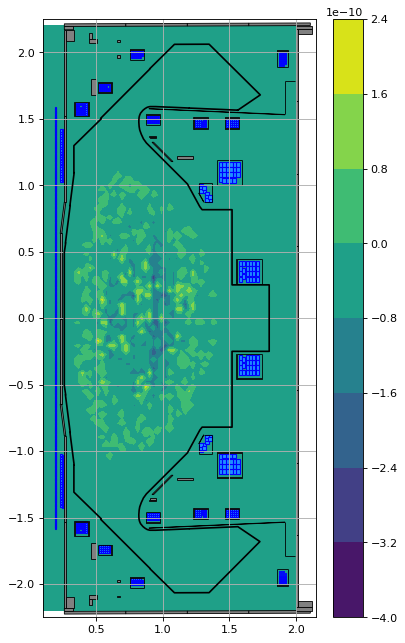

In [25]:
laoj = profiles_lao.Jtor(R=eq.R, Z=eq.Z, psi=eq.psi())
topj = profiles_topeol.Jtor(R=eq.R, Z=eq.Z, psi=eq.psi())


fig1, ax1 = plt.subplots(1, 1, figsize=(5, 8), dpi=80)
ax1.grid(True, which='both')
plt.contourf(eq.R, eq.Z, (laoj-topj))
eq.tokamak.plot(axis=ax1, show=False)
plt.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, 'k', 1.2)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()
plt.colorbar()

FreeGSNKE also enables one to specify a set of Topeol profile parameters that best fit a set of Lao85 parameters (using the Lao_parameters method).

In [26]:
alpha, beta = profiles_topeol.Lao_parameters(n_alpha=2, n_beta=2, alpha_logic=True, beta_logic=True)
print(f"Original alpha's = {profiles_lao.alpha[0:2]} vs. Fitted from Topeol = {alpha}.")
print(f"Original beta's = {profiles_lao.beta[0:2]} vs. Fitted from Topeol = {beta}.")


Original alpha's = [1 0] vs. Fitted from Topeol = [ 1.00000000e+00 -9.14546217e-15].
Original beta's = [2.17211345e-06 0.00000000e+00] vs. Fitted from Topeol = [ 2.17211345e-06 -1.97142607e-20].


In [27]:
profiles_lao_fit = Lao85(
    eq=eq,
    Ip=6e5,
    fvac=0.5,
    alpha=alpha,
    beta=beta,
    alpha_logic=True,
    beta_logic=True,
)

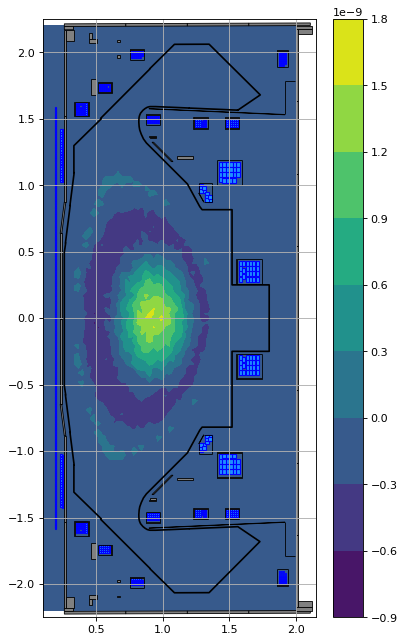

In [28]:
laoj = profiles_lao_fit.Jtor(R=eq.R, Z=eq.Z, psi=eq.psi())
topj = profiles_topeol.Jtor(R=eq.R, Z=eq.Z, psi=eq.psi())


fig1, ax1 = plt.subplots(1, 1, figsize=(5, 8), dpi=80)
ax1.grid(True, which='both')
plt.contourf(eq.R, eq.Z, (laoj-topj))
eq.tokamak.plot(axis=ax1, show=False)
plt.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, 'k', 1.2)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()
plt.colorbar()

The reverse is also possible, using the the Topeol_parameters method in the Lao85 profile object.

In [29]:
alpha_m, alpha_n, beta_0 = profiles_lao_fit.Topeol_parameters()

print(f"Original alpha_m = {profiles_topeol.alpha_m} vs. Fitted from Lao85 = {alpha_m}.")
print(f"Original alpha_n = {profiles_topeol.alpha_n} vs. Fitted from Lao85 = {alpha_n}.")
print(f"Original beta_0 = {profiles_topeol.Beta0} vs. Fitted from Lao85 = {beta_0}.")

Original alpha_m = 2 vs. Fitted from Lao85 = 2.0000000837960568.
Original alpha_n = 1 vs. Fitted from Lao85 = 1.0000000244807388.
Original beta_0 = 0.3665 vs. Fitted from Lao85 = 0.3664999995587856.


### Forward solve: limiter plasma

Here we use the saved limiter plasma currents from the prior notebook. 

rescaling accepted by0.6830134553650705


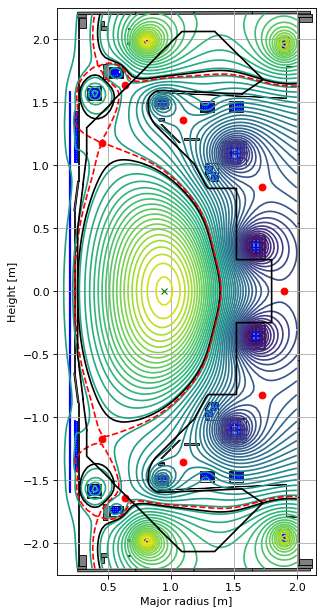

In [30]:
# initialise the equilibrium
eq_limiter = deepcopy(eq)


# initialise the profiles
profiles = ConstrainPaxisIp(
    eq=eq_limiter,        # equilibrium object
    paxis=6e3,    # profile object
    Ip=4e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

# load the nonlinear solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq_limiter)    

# set the coil currents
import pickle
with open('simple_limited_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq_limiter.tokamak.set_coil_current(coil_label=key, current_value=current_values[key])

# carry out the foward solve to find the equilibrium
GSStaticSolver.solve(eq=eq_limiter, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq_limiter.plot(axis=ax1, show=False)
eq_limiter.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()